Case of Use: Aircraft recognition testing.

This project focuses on building a computer vision model that classifies different types of airplanes using the FGVC-Aircraft dataset.


In [1]:
!pip install tensorflow --quiet
import tensorflow as tf
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np

1.dataset import. we'll be using a largely recognized aircraft dataset called FGVC

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar -xvzf fgvc-aircraft-2013b.tar.gz

Streaming output truncated to the last 5000 lines.
fgvc-aircraft-2013b/data/images/0716452.jpg
fgvc-aircraft-2013b/data/images/0683550.jpg
fgvc-aircraft-2013b/data/images/0192881.jpg
fgvc-aircraft-2013b/data/images/0818052.jpg
fgvc-aircraft-2013b/data/images/0744239.jpg
fgvc-aircraft-2013b/data/images/2170875.jpg
fgvc-aircraft-2013b/data/images/1256475.jpg
fgvc-aircraft-2013b/data/images/2075105.jpg
fgvc-aircraft-2013b/data/images/0962825.jpg
fgvc-aircraft-2013b/data/images/1641331.jpg
fgvc-aircraft-2013b/data/images/1426707.jpg
fgvc-aircraft-2013b/data/images/1312743.jpg
fgvc-aircraft-2013b/data/images/1391858.jpg
fgvc-aircraft-2013b/data/images/0184346.jpg
fgvc-aircraft-2013b/data/images/0894188.jpg
fgvc-aircraft-2013b/data/images/1852173.jpg
fgvc-aircraft-2013b/data/images/0767364.jpg
fgvc-aircraft-2013b/data/images/1148366.jpg
fgvc-aircraft-2013b/data/images/0773403.jpg
fgvc-aircraft-2013b/data/images/1308386.jpg
fgvc-aircraft-2013b/data/images/1375264.jpg
fgvc-aircraft-2013b/data/

2. Data cleansing:
Now we'll be sorting the aircraft images by model on subfolders.

In [3]:
import os
import shutil
from tqdm import tqdm

# base route of decompressed dataset
base_path = "fgvc-aircraft-2013b"
images_path = os.path.join(base_path, "data", "images")
annotations_path = os.path.join(base_path, "data", "images_variant_train.txt")

# target  folder
output_dir = "organized_dataset/train"
os.makedirs(output_dir, exist_ok=True)

# disclaimer: each line is an aircraft class
with open(annotations_path, 'r') as f:
    lines = f.readlines()

for line in tqdm(lines):
    parts = line.strip().split(" ")
    image_name = parts[0] + ".jpg"
    class_name = "_".join(parts[1:])

    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    src = os.path.join(images_path, image_name)
    dst = os.path.join(class_dir, image_name)

    if os.path.exists(src):
        shutil.copy2(src, dst)


100%|██████████| 3334/3334 [00:07<00:00, 466.47it/s]


3. Preprocessing. We'll be using TensorFlow ImageDataGen methods for data augmentation and validation splitting

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15
)

train_data = datagen.flow_from_directory(
    "organized_dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    "organized_dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2734 images belonging to 100 classes.
Found 600 images belonging to 100 classes.


4. Building model using MobileNetV2

Using said model for transfer learning assures optimal performance due to its lightweight architecture, which is ideal for fast performance and low resource usage while still providing strong accuracy, freezing its layers to leverage its pre-learned features and adding custom layers for the specific aircraft sorting task.

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,620 (9.96 MB)

 Trainable params: 353,636 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

5.model training

The model is trained on the dataset for 10 epochs, note that early stopping is implemented to prevent overfitting




In [6]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.0268 - loss: 4.6319 - val_accuracy: 0.0700 - val_loss: 4.2454
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.1097 - loss: 3.9550 - val_accuracy: 0.0783 - val_loss: 3.9106
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.1546 - loss: 3.4851 - val_accuracy: 0.1250 - val_loss: 3.6502
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.2232 - loss: 3.1353 - val_accuracy: 0.1733 - val_loss: 3.4561
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.2928 - loss: 2.8418 - val_accuracy: 0.1733 - val_loss: 3.4140
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3171 - loss: 2.6187 - val_accuracy: 0.1833 - val_loss: 3.2768
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.3670 - loss: 2.4315 - val_accuracy: 0.1867 - val_loss: 3.3071
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.4070 - loss: 2.2543 - val_accuracy: 0.2183 - v

6. model evaluation


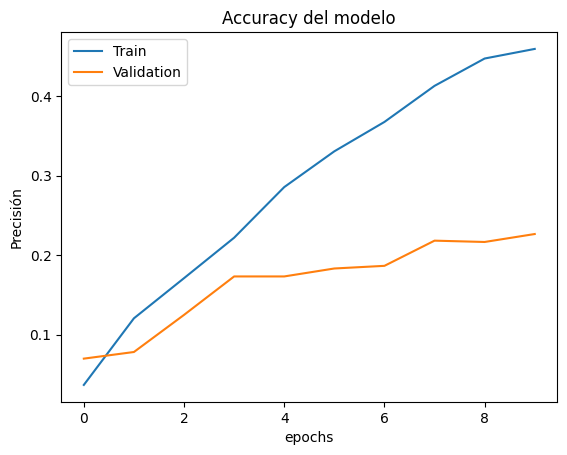

In [9]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy del modelo")
plt.xlabel("epochs")
plt.ylabel("Precisión")
plt.legend()
plt.show()


6. Aircraft recognition testing. Followed by visual and manual inspection.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


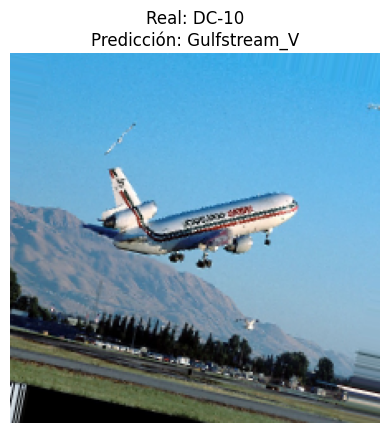

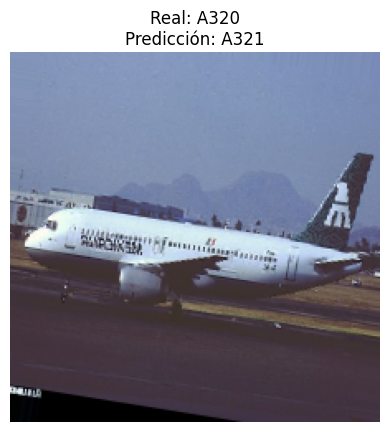

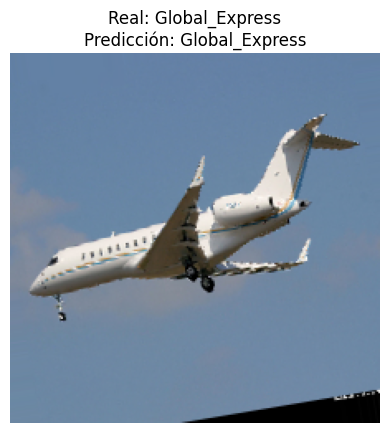

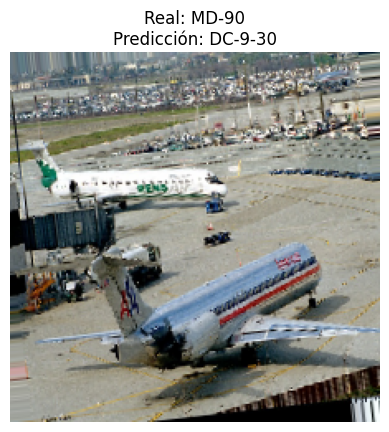

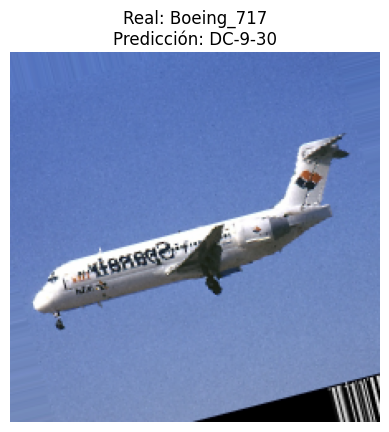

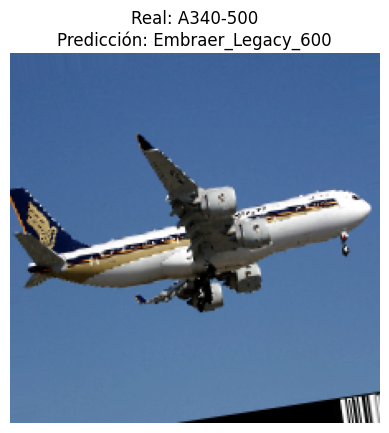

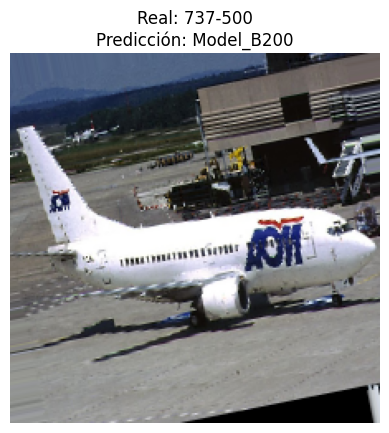

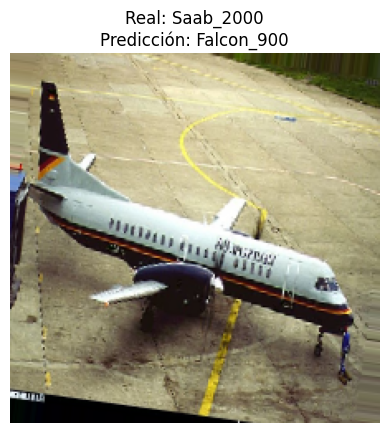

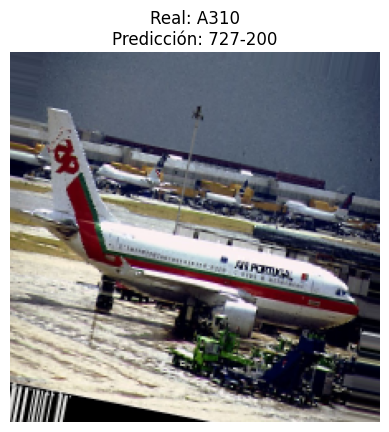

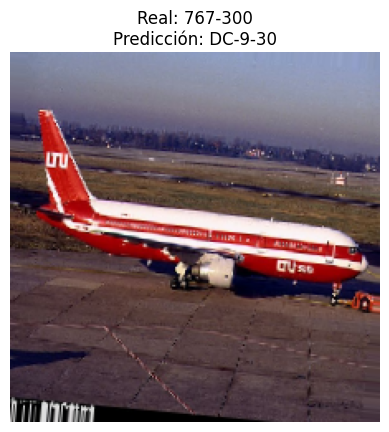

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# tiny batch for testing purposes
images, labels = next(val_data)

# prediction making
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)
class_labels = list(train_data.class_indices.keys())

# show some images correctly identified
for i in range(10):
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Real: {class_labels[true_classes[i]]}\nPredicción: {class_labels[predicted_classes[i]]}")
    plt.show()


Model prediction not so accurate, keep in mind DeHavilland models are really similar with eachother hence why it can lead to confusion, however boeing models (b-737,etc) were nowhere near accurate